# Bus Stops on SHN in CA

Uriel's request:

Can you help me get a copy of the dataset (Excel or .csv) for bus stops that are on the SHS?

I am looking for an Excel or .csv dataset that shows only the bus stops on the SHS.  A filtered, tabulated data of them based on a snapshot of the most recent dataset is fine.  Gillian wants to move this sub-dataset into Entur for protoyping purposes.

In [1]:
import os
os.environ["CALITP_BQ_MAX_BYTES"] = str(200_000_000_000)

import geopandas as gpd
import pandas as pd
from siuba import *

from segment_speed_utils import helpers
from shared_utils import catalog_utils, rt_dates, gtfs_utils_v2

SCHED_GCS = "gs://calitp-analytics-data/data-analyses/gtfs_schedule/"

In [2]:
shared_data_catalog = catalog_utils.get_catalog("shared_data_catalog")

In [3]:
shn = shared_data_catalog.state_highway_network.read()

# 100 ft buffer around SHN
shn = shn.assign(
    geometry_buffered = (shn.geometry.to_crs("EPSG:2229")
                         .buffer(100)
                         .to_crs("EPSG:4326")
                        )
)

<AxesSubplot:>

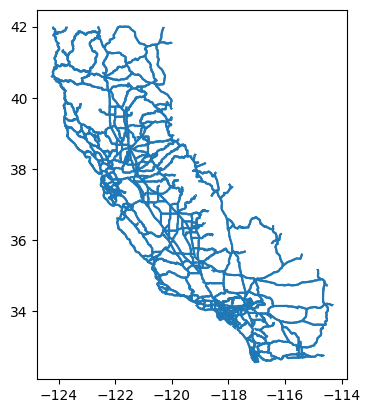

In [4]:
shn.plot()

In [5]:
ca_stops = shared_data_catalog.ca_transit_stops.read()

In [6]:
ca_stops['date'] = rt_dates.DATES['aug2024'] #  change to match most recent open data upload...

In [10]:
unique_stop_cols = ["agency", "stop_id", "stop_name",
                        "route_type", "date"]

In [11]:
def sjoin_shs(stops: gpd.GeoDataFrame):
    
    stops_on_shn = gpd.sjoin(
        stops, 
        shn[
            ["Route", "RouteType", "geometry_buffered"]
        ].set_geometry("geometry_buffered"),
        how = "inner",
        predicate = "intersects"
    ).drop(columns = "index_right")

    print(stops_on_shn[unique_stop_cols].drop_duplicates().shape)
    return stops_on_shn

In [12]:
def process_for_export(stops: gpd.GeoDataFrame):

    # Export / rename columns for clarity / get it as csv so back out lat/lon
    stops_for_export = stops[
        unique_stop_cols + ["Route", "RouteType", "geometry"]
    ].rename(columns = {
        "Route": "shn_route",
        "RouteType": "shn_route_type"}
    ).drop_duplicates().reset_index(drop=True)

    stops_for_export = stops_for_export.assign(
        x = stops_for_export.geometry.x,
        y = stops_for_export.geometry.y,
    ).drop(columns = "geometry")

    return stops_for_export

In [13]:
aug_stops_for_export = process_for_export(sjoin_shs(ca_stops))

(5222, 5)


In [14]:
# stops_on_shn.explore()

# adding SBMTD

## where'd it go?

In [15]:
analysis_date = rt_dates.DATES['aug2024'] #  start with same date as open data run (Aug 14)

In [16]:
sb = gtfs_utils_v2.schedule_daily_feed_to_gtfs_dataset_name(selected_date=analysis_date)

In [17]:
sb = sb >> filter(_.name.str.contains('SB'))
sb

,key,date,feed_key,feed_timezone,base64_url,gtfs_dataset_key,name,type,regional_feed_type
40,fd8113bb3d968a3d10cc34d728b768e8,2024-08-14,dc50d111693842f1f2e8067cb0ad11e1,America/Los_Angeles,aHR0cHM6Ly9zYm10ZC5nb3YvZ29vZ2xlX3RyYW5zaXQvZm...,239f3baf3dd3b9e9464f66a777f9897d,SBMTD Schedule,schedule,None


In [18]:
sb_stops = gtfs_utils_v2.get_stops(selected_date=analysis_date, operator_feeds=sb.feed_key)

/opt/conda/lib/python3.9/site-packages/sqlalchemy_bigquery/_types.py:101: SAWarning: Did not recognize type 'GEOGRAPHY' of column 'pt_geom'
  sqlalchemy.util.warn(


In [19]:
sb_stops >> head(3) #  empty

,key,service_date,feed_key,stop_id,feed_timezone,stop_event_count,first_stop_arrival_datetime_pacific,last_stop_departure_datetime_pacific,_feed_valid_from,route_type_0,...,stop_key,tts_stop_name,parent_station,stop_code,stop_name,stop_desc,location_type,stop_timezone_coalesced,wheelchair_boarding,geometry


### classic upload with coverage gap (uploaded ~8/14, service in feed starts ~8/19)

https://github.com/cal-itp/data-infra/issues/1300

## here it is

In [20]:
analysis_date = '2024-08-21'

In [21]:
sb = gtfs_utils_v2.schedule_daily_feed_to_gtfs_dataset_name(selected_date=analysis_date)
sb = sb >> filter(_.name.str.contains('SB'))
sb

,key,date,feed_key,feed_timezone,base64_url,gtfs_dataset_key,name,type,regional_feed_type
40,80c316ec6d54ae485afa231d1a619fa8,2024-08-21,dc50d111693842f1f2e8067cb0ad11e1,America/Los_Angeles,aHR0cHM6Ly9zYm10ZC5nb3YvZ29vZ2xlX3RyYW5zaXQvZm...,239f3baf3dd3b9e9464f66a777f9897d,SBMTD Schedule,schedule,None


In [22]:
sb_stops = gtfs_utils_v2.get_stops(selected_date=analysis_date, operator_feeds=sb.feed_key)

/opt/conda/lib/python3.9/site-packages/sqlalchemy_bigquery/_types.py:101: SAWarning: Did not recognize type 'GEOGRAPHY' of column 'pt_geom'
  sqlalchemy.util.warn(


In [23]:
sb_trips = gtfs_utils_v2.get_trips(selected_date=analysis_date, operator_feeds=sb.feed_key)

In [24]:
sb_trips.empty

False

In [25]:
sb_stops >> head(2)

,key,service_date,feed_key,stop_id,feed_timezone,stop_event_count,first_stop_arrival_datetime_pacific,last_stop_departure_datetime_pacific,_feed_valid_from,route_type_0,...,stop_key,tts_stop_name,parent_station,stop_code,stop_name,stop_desc,location_type,stop_timezone_coalesced,wheelchair_boarding,geometry
0,2402300a33d09fc032760d297284eead,2024-08-21,dc50d111693842f1f2e8067cb0ad11e1,46,America/Los_Angeles,1,2024-08-21 09:02:00,2024-08-21 09:02:00,2024-08-06 03:00:22.899627+00:00,None,...,ccbdb033135b5b8540250406d0520282,None,None,136,Cathedral Oaks & Alpha Resource,None,None,America/Los_Angeles,2,POINT (-119.77610 34.45135)
1,2c586cda06751c44f0a815f4e8c632b9,2024-08-21,dc50d111693842f1f2e8067cb0ad11e1,51,America/Los_Angeles,1,2024-08-21 15:12:03,2024-08-21 15:12:03,2024-08-06 03:00:22.899627+00:00,None,...,28d3ba5e59836c8536174f93bb72fbf7,None,None,153,Cota & Olive,None,None,America/Los_Angeles,2,POINT (-119.69137 34.42294)


In [26]:
#  lifted from https://github.com/cal-itp/data-analyses/blob/main/open_data/create_stops_data.py
export_stops_path = 'gs://calitp-analytics-data/data-analyses/traffic_ops/export/ca_transit_stops_'

In [27]:
analysis_date = rt_dates.DATES['jul2024']

In [28]:
jul_stops = gpd.read_parquet(f'{export_stops_path}{analysis_date}.parquet', filters=[('agency', '==', 'Santa Barbara Metropolitan Transit District')])

In [29]:
jul_stops['date'] = analysis_date

## now B-Line

In [30]:
analysis_date = rt_dates.DATES['mar2024']

In [31]:
mar_stops = gpd.read_parquet(f'{export_stops_path}{analysis_date}.parquet'
                             , filters=[('agency', '==', 'Butte County Association of Governments')]
                            )
mar_stops['date'] = analysis_date

## now LBT

In [32]:
analysis_date = rt_dates.DATES['may2024']

In [33]:
may_stops = gpd.read_parquet(f'{export_stops_path}{analysis_date}.parquet'
                             , filters=[('agency', '==', 'Long Beach Transit')]
                            )
may_stops['date'] = analysis_date

## concat and process

In [34]:
stops_to_add = pd.concat([jul_stops, mar_stops, may_stops])

In [35]:
# stops_to_add.explore()

In [36]:
additional_shs_stops = sjoin_shs(stops_to_add)

(171, 5)


In [42]:
# additional_shs_stops.explore()

In [38]:
analysis_date = rt_dates.DATES['jul2024']

In [39]:
import sys
sys.path.append('../gtfs_funnel/')

In [ ]:
import update_vars #  no update_vars here so won't clash 

In [ ]:
stops_gcs = update_vars.COMPILED_CACHED_VIEWS
stops_gcs

In [ ]:
update_vars.GTFS_DATA_DICT.schedule_downloads.stops #  TIL you can . access a dict

In [ ]:
july_stops = gpd.read_parquet(f'{stops_gcs}stops_{analysis_date}.parquet')

In [ ]:
july_stops.columns

# new combined export

In [40]:
stops_for_export = pd.concat([aug_stops_for_export, process_for_export(additional_shs_stops)])

In [41]:
stops_for_export.to_csv("ca_stops_revised.csv", index=False)